## Install dependencies

This may take a long time ... ~ 20 mins


In [ ]:
%pip install -r requirements.txt

## Upload data

Group images by separating each class into one folder then wrap all the folder into another folder.

Ex.
```
data/ 
  │
  └─── class1/
  │        │
  |        └─── image1.png
  │        └─── image2.jpg
  |        └─── ...
  │   
  └─── class2/
  │        │
  |        └─── image123.png
  │        └─── image456.jpg
  |        └─── ...
  |
  └─── .../
           │
           └─── ...
```





## Remove unecessary files

Image file extension that are only acceptable are selected in the `image_exts`.

In [1]:
import imghdr, os
import numpy as np

In [2]:
data_dir = './Banana Leaf Disease'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [4]:
nr = 0
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print(f'Image not in ext list {image_path}')
        os.remove(image_path)
        nr += 1
    except Exception as e:
        print(f'Issue with image {image_path}')

print(f'Removed {nr} unwanted files.')

Removed 0 unwanted files.


## Configure settings

Apply all the settings here for preprocessing, building, and training the neural network.

In [5]:
IMAGE_SIZE = (256, 256) # Square sized are recommended for stability
EPOCHS = 20
BATCH_SIZE = 32
KERNEL_SIZE = (3, 3)
STRIDES = 1

# Ratio for splitting dataset
TRAIN_VAL = 0.8
VALID_VAL = 0.2
assert TRAIN_VAL + VALID_VAL == 1, 'Ratio must be added to 100%'

## Prepare and randomize the images

Randomly split input and output pairs into sets of data: 80% for training, 20% for validation.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training

Using the `tf.keras.utils.image_dataset_from_directory`, we can prepare our dataset easily.

See https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [6]:
import tensorflow as tf

In [13]:
train_data = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 1-TRAIN_VAL, # reserve for validation
  subset="training",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  shuffle=True)

val_data = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=VALID_VAL,
  subset="validation",
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  shuffle=True)

class_names = train_data.class_names
print(class_names)

Found 267 files belonging to 4 classes.
Using 214 files for training.
Found 267 files belonging to 4 classes.
Using 53 files for validation.
['Black Sigatoka', 'Healthy', 'Panama Disease', 'Yellow Sigatoka']


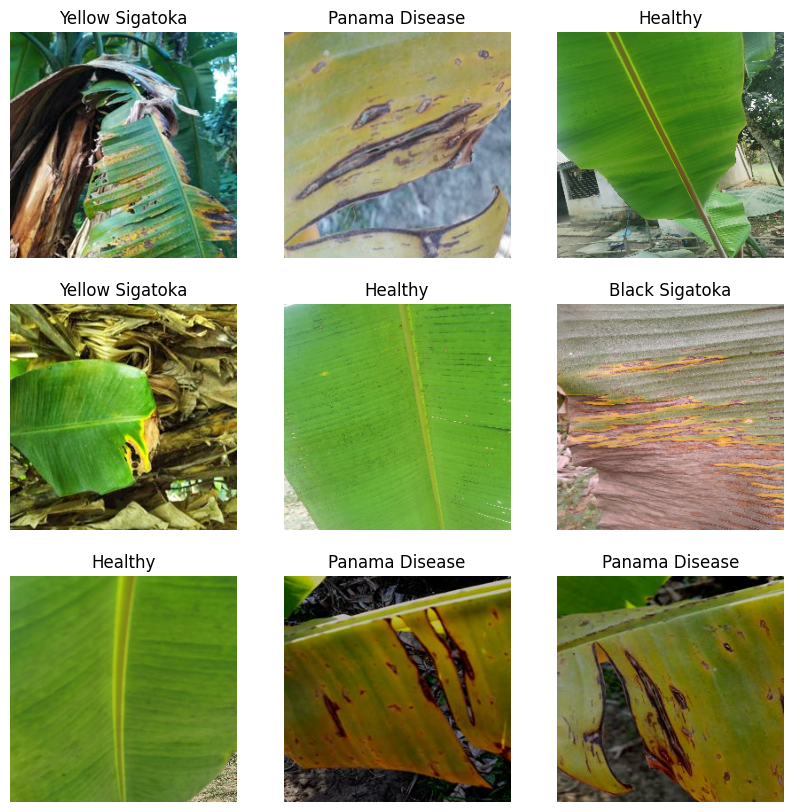

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  

In [16]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


## Configure the dataset for performance

* [Dataset.cache](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

* [Dataset.prefetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

## Data augmentation

Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal", input_shape=IMAGE_SIZE+(3,)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using [tf.keras.layers.Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling).

In [21]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

### Build the neural network

In [22]:
num_classes = len(class_names)

model = tf.keras.models.Sequential()

model.add(data_augmentation)
model.add(normalization_layer)

model.add(tf.keras.layers.Conv2D(16, KERNEL_SIZE, STRIDES, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(32, KERNEL_SIZE, STRIDES, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(64, KERNEL_SIZE, STRIDES, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, name="outputs"))


model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

### Train

In [23]:
history = model.fit(train_data, epochs=20, validation_data=val_data)

Epoch 1/20
7/7 [==============================] - 18s 2s/step - loss: 1.3161 - accuracy: 0.4206 - val_loss: 1.0819 - val_accuracy: 0.5472
Epoch 2/20
7/7 [==============================] - 12s 2s/step - loss: 0.9909 - accuracy: 0.6308 - val_loss: 0.9153 - val_accuracy: 0.6038
Epoch 3/20
7/7 [==============================] - 12s 2s/step - loss: 0.8695 - accuracy: 0.6215 - val_loss: 0.8081 - val_accuracy: 0.7547
Epoch 4/20
7/7 [==============================] - 11s 1s/step - loss: 0.6655 - accuracy: 0.7243 - val_loss: 0.7254 - val_accuracy: 0.7358
Epoch 5/20
7/7 [==============================] - 11s 2s/step - loss: 0.5184 - accuracy: 0.7757 - val_loss: 0.6622 - val_accuracy: 0.7547
Epoch 6/20
7/7 [==============================] - 10s 1s/step - loss: 0.3773 - accuracy: 0.8692 - val_loss: 1.4112 - val_accuracy: 0.6792
Epoch 7/20
7/7 [==============================] - 10s 1s/step - loss: 0.2838 - accuracy: 0.8879 - val_loss: 1.0755 - val_accuracy: 0.7358
Epoch 8/20
7/7 [==================

## Visualize training results
Create plots of the loss and accuracy on the training and validation sets:

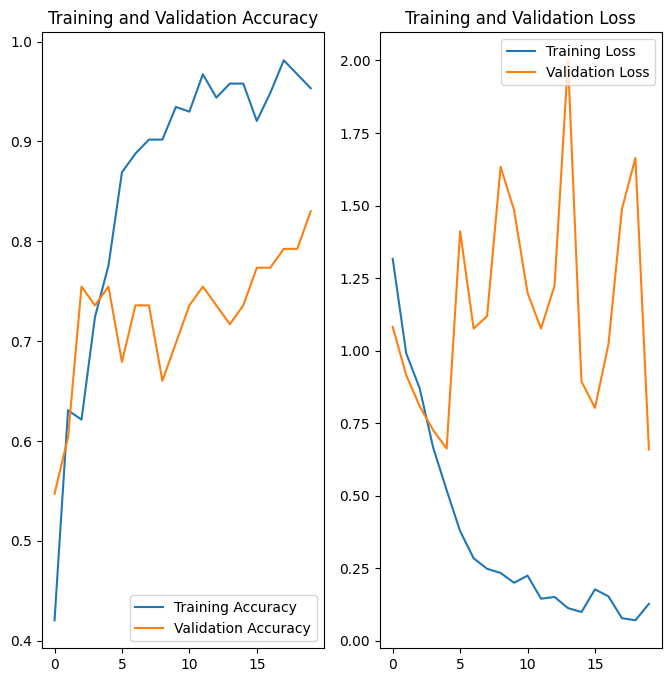

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save the model

 To test different brand new images that are not in the `data_dir`.

### .h5

In [25]:
model.save('./models/model.h5')

### .tflite

In [26]:
# Convert the model to the TensorFlow Lite format

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# # USE QUANTIZATION
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Save the model to disk
open("./models/model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Bahillo\AppData\Local\Temp\tmpmjbxgjzb\assets


INFO:tensorflow:Assets written to: C:\Users\Bahillo\AppData\Local\Temp\tmpmjbxgjzb\assets


33655384

#### Optional
For edge devices, see [supported platforms](https://www.tensorflow.org/lite/microcontrollers#supported_platforms)

If the device requires to use C header file (.h) ...





In [27]:
def hex_to_c_array(hex_data) -> str:
    # Declare C variable
    c_str = 'unsigned char model[] = {'
    hex_array = []

    for i, val in enumerate(hex_data):
        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n'
        hex_array.append(hex_str)

    # Wrapping up
    c_str += '\n ' + format(' '.join(hex_array)) + '};'

    return c_str

with open('./models/model.h', 'w') as f:
    content = hex_to_c_array(tflite_model)
    f.write(content)

## Test new images

### Load the model using the **.h5** file

In [28]:
loaded_model =  tf.keras.models.load_model('./models/model.h5')

### Test the result

In [29]:
img = tf.keras.utils.load_img('happytest.jpg', target_size=IMAGE_SIZE) # replace with your file name here
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # create a batch

yhat = model.predict(img_array)
score = tf.nn.softmax(yhat[0])

print(score)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 1s/step
[ 13.737184  -41.01871     9.704219    8.5524435]
This image most likely belongs to Black Sigatoka with a 1373.72 percent confidence.
